# Reassessment of ABP Attributes for ATT

by `Xiaoli Qiu`

created: `2022-03-28`

JIRA: https://clearlink.atlassian.net/browse/ONE-8732

<br>

## TOC
- [Date Ranges](#data_range)
- [Independence Test](#correlation)
- [Training with Different Attributes](#training)
- [TL;DR](#tldr)

In [304]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2022-04-06 09:56:35.011192


In [2]:
import pandas as pd
import numpy as np 

In [35]:
import matplotlib.pyplot as plt  
plt.style.use('dark_background')
import seaborn as sns
%matplotlib inline

In [302]:
from scipy.stats import chi2_contingency 
from scipy.stats import chi2
from itertools import combinations

In [30]:
def chi_square_test(df):
    """
    Function for performing chi-square test.
    :param df: targe dataframe
    :return: (1) chi-square values in dataframe and (2) p-values in dataframe. The columns names and index are the same. 
    """
    cols = list(df.columns)
    resultant_p = pd.DataFrame(data=[(0 for i in range(len(cols))) for i in range(len(cols))], 
                         columns=cols)
    resultant_p.set_index(pd.Index(cols), inplace = True)
    resultant_chi = resultant_p.copy(deep=True)

    # Finding p_value for all columns and putting them in the resultant matrix
    for i in cols:
        for j in cols:
            if i != j:
                chi2_val, p_val, _, _ = chi2_contingency(pd.crosstab(df[i], df[j]))
#                 chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
                resultant_p.loc[i,j] = p_val
                resultant_chi.loc[i,j] = chi2_val
                
    return tuple([resultant_chi, resultant_p])


In [3]:
import psycopg2

In [64]:
con = psycopg2.connect(dbname = 'datawarehouse', host ='dw_prod.clearlinkdata.com', 
                       port = '5439', user = username, password = password)

# con = psycopg2.connect(dbname = 'datawarehouse_stage', host ='dw_stage.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)

In [8]:
get_conv_training_set = """
SELECT date_prequeue, contact_id, brand_skilled, intent_lookup_flag, consent_flag, 
    CASE WHEN channel = 'Pay Per Click' THEN 1 ELSE 0 END       AS channel_is_ppc, marketing_tier, 
    is_weekday, max_speed_qual, is_converted
FROM data_warehouse.call_detail_attribute_log
WHERE brand_skilled IN {brands_skilled} 
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND call_conclusion = 'Answered'
ORDER BY 1;
"""

get_revenue_training_set = """
SELECT
*
FROM (
(SELECT date_prequeue,
       contact_id,
       brand_skilled,
       intent_lookup_flag,
       consent_flag,
       CASE WHEN channel = 'Pay Per Click' THEN 1 ELSE 0 END                       AS channel_is_ppc,
       cdal.marketing_tier,
       is_weekday,
       max_speed_qual,
       is_converted,
       cdal.sku,
       cdal.unit_count,
       lfk.revenue
FROM data_warehouse.call_detail_attribute_log cdal
         LEFT JOIN data_warehouse.lookup_finance_kpi_sku_revenue_latest lfk
                   ON cdal.sku = lfk.sku AND cdal.brand_marketed = lfk.brand_marketed
                       AND cdal.brand_ordered = lfk.brand_ordered AND
                      cdal.financial_sale_creation_type = lfk.financial_sale_creation_type AND
                      cdal.is_overflow = lfk.is_overflow AND cdal.marketing_tier=lfk.marketing_tier
WHERE cdal.brand_ordered IN ('EMBC', 'QWEC', 'EMB', 'QWE')
AND brand_skilled IN {brands_skilled}
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND is_converted = 1
AND call_conclusion = 'Answered'
ORDER BY 1,2)
UNION
(SELECT date_prequeue,
       contact_id,
       brand_skilled,
       intent_lookup_flag,
       consent_flag,
       CASE WHEN channel = 'Pay Per Click' THEN 1 ELSE 0 END                       AS channel_is_ppc,
       cdal.marketing_tier,
       is_weekday,
       max_speed_qual,
       is_converted,
       cdal.sku,
       cdal.unit_count,
       lfk.revenue
FROM data_warehouse.call_detail_attribute_log cdal
         LEFT JOIN data_warehouse.lookup_finance_kpi_sku_revenue_latest lfk
                   ON cdal.sku = lfk.sku AND cdal.brand_marketed = lfk.brand_marketed
                       AND cdal.brand_ordered = lfk.brand_ordered AND
                      cdal.financial_sale_creation_type = lfk.financial_sale_creation_type AND
                      cdal.is_overflow = lfk.is_overflow
WHERE cdal.brand_ordered NOT IN ('EMBC', 'QWEC', 'EMB', 'QWE')
AND brand_skilled IN {brands_skilled}
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND is_converted = 1
AND call_conclusion = 'Answered'
ORDER BY 1,2));
"""

get_online_aq_contact_ids = """
SELECT DISTINCT cd.contact_id
FROM data_warehouse.call_detail cd
 JOIN data_warehouse.call_detail_rel_ivr_routes cdr ON cdr.contact_id = cd.contact_id
 LEFT JOIN data_warehouse.lookup_cd_ivr_route_ids lcr ON cdr.lookup_cd_ivr_route_ids_id = lcr.id
WHERE lcr.id IN (691, 746)
AND brand_skilled IN {brands_skilled}
AND DATE(cd.date_prequeue_start) >= '{train_start_date}'
AND DATE(cd.date_prequeue_start) <= '{train_end_date}'
AND call_type = 'I'
AND call_purpose = 'Sales'
AND call_conclusion = 'Answered';
"""

In [9]:
valid_sq_speeds = [5000, 1000, 75, 50, 18, 10, 25, 100, 5, 2, 1, 0]
revenue_limit = [20, 600]
brand_skilled = ['ATT']
cur_date = '2022-02-28'

max_valid_speeds = "({valid_speeds}, 'NA')".format(valid_speeds=', '.join(map(str, ["'{x}'".format(x=x) for x in valid_sq_speeds])))
brands_skilled ="({skilled})".format(skilled=", ".join("'" + item + "'" for item in brand_skilled))

In [10]:
train_set_conv = pd.read_sql(get_conv_training_set.format(train_start_date='2020-03-02', train_end_date=cur_date, valid_speeds=max_valid_speeds, brands_skilled=brands_skilled), con)
train_set_revenue = pd.read_sql(get_revenue_training_set.format(train_start_date='2020-03-02', train_end_date=cur_date, valid_speeds=max_valid_speeds, brands_skilled=brands_skilled), con)
online_aq_ids = pd.read_sql(get_online_aq_contact_ids.format(train_start_date='2020-03-02', train_end_date=cur_date, brands_skilled=brands_skilled), con)

In [11]:
# train_set_conv.to_pickle('conv_train_set_20220301.pkl')
# train_set_revenue.to_pickle('rev_train_set_20220301.pkl')
# online_aq_ids.to_pickle('onlineAQSids_set_20220301.pkl')

In [ ]:
# train_set_conv = pd.read_pickle('conv_train_set_20220301.pkl')
# train_set_revenue = pd.read_pickle('rev_train_set_20220301.pkl')
# online_aq_ids = pd.read_pickle('onlineAQSids_set_20220301.pkl')

In [12]:
train_set_conv

date_prequeue    contact_id brand_skilled  intent_lookup_flag  \
0         2020-03-02  124542114649           ATT                   1   
1         2020-03-02  124541980391           ATT                   2   
2         2020-03-02  124469359347           ATT                   1   
3         2020-03-02  124542067084           ATT                   1   
4         2020-03-02  124469157534           ATT                   1   
...              ...           ...           ...                 ...   
536341    2022-02-28  196914899231           ATT                   2   
536342    2022-02-28  196915001754           ATT                   2   
536343    2022-02-28  196915004249           ATT                   1   
536344    2022-02-28  196915006468           ATT                   1   
536345    2022-02-28  196915006499           ATT                   0   

        consent_flag  channel_is_ppc marketing_tier  is_weekday  \
0                  1               1                          1   
1                  1               1                          1   
2                  0               0                          1   
3                  0               1                          1   
4                  1               1                          1   
...              ...             ...            ...         ...   
536341             1               1           MISC           1   
536342             1               1           MISC           1   
536343             0               1           MISC           1   
536344             1               0                          1   
536345             1               1           MISC           1   

       max_speed_qual  is_converted  
0                  NA             0  
1                  NA             0  
2                  NA             0  
3                  NA             1  
4                  NA             0  
...               ...           ...  
536341             50             1  
536342             NA             1  
536343             NA             0  
536344             75             0  
536345           1000             1  

[536346 rows x 10 columns]

In [13]:
def create_training_set(train_set_conv, train_set_revenue, marketing_groups, online_aq_ids, revenue_limit, cur_date, train_days):
    """
    Function to create training sets for conversion and revenue models
    :param train_set_conv: conversion training set df
    :param train_set_revenue: revenue training set df
    :param marketing_groups: grouped marketing tiers
    :param online_aq_ids: online AQS ids to be excluded
    :param revenue_limit: revenue limits for revenue training set
    :param cur_date: current date
    :param train_days: number of most recent calendar days to be included in the training set
    :return: processed row training set
    """
    # Select appropriate dates for traninig
    train_set_conv['date_prequeue'] = pd.to_datetime(train_set_conv['date_prequeue'])
    train_set_revenue['date_prequeue'] = pd.to_datetime(train_set_revenue['date_prequeue'])
    
    end = datetime.datetime.strptime(cur_date, '%Y-%m-%d').date()
    begin = (end - pd.offsets.Day(train_days)).date()
    
    train_set_conv_dates = train_set_conv[(train_set_conv['date_prequeue'].dt.date <= end) & (train_set_conv['date_prequeue'].dt.date >= begin)]
    train_set_revenue_dates = train_set_revenue[(train_set_revenue['date_prequeue'].dt.date <= end) & (train_set_revenue['date_prequeue'].dt.date >= begin)]
    
    train_set_conv_processed = process_training_set(train_set_conv_dates, marketing_groups, online_aq_ids)
    train_set_revenue_processed = process_rev_training_set(train_set_revenue_dates, revenue_limit, marketing_groups, online_aq_ids)
    
    return tuple([train_set_conv_processed, train_set_revenue_processed])

def process_training_set(train_set, marketing_groups, online_aq_ids):
    """
    Function to build rows for the training set
    :param train_set: training set data frame
    :return: processed row training set
    """
    # logging.info('Number of records: ')
    # logging.info(train_set.shape[0])
    train_set = train_set[~train_set['contact_id'].astype(int).isin(online_aq_ids['contact_id'].astype(int))].copy()
    # logging.info('Number of records after removing online address qual: ')
    # logging.info(train_set.shape[0])

    if marketing_groups is not None:
        train_set['marketing_tier'] = train_set['marketing_tier'].map(marketing_groups)
        train_set['marketing_tier'].fillna('G4', inplace=True)
        # logging.info('Marketing tier ratios: ')
        # logging.info(train_set['marketing_tier'].value_counts())
        # logging.info(train_set['marketing_tier'].value_counts(normalize=True) * 100)
    else:
        train_set.loc[:, 'marketing_tier'] = 'NA'
        # logging.info(train_set['marketing_tier'].unique())

    train_set.rename(columns={'marketing_tier': 'marketing_tier_group'}, inplace=True)

    cols = ['intent_lookup_flag', 'consent_flag', 'channel_is_ppc',
            'marketing_tier_group', 'max_speed_qual', 'is_weekday']

    for c in cols:
        train_set[c] = train_set[c].astype('category')

    # logging.info('Class ratios before dropping the duplicates: ')
    # logging.info(train_set['is_converted'].value_counts())
    # logging.info(train_set['is_converted'].value_counts(normalize=True) * 100)

    train_set = train_set.sort_values('is_converted', ascending=False).drop_duplicates(subset=['contact_id'],
                                                                                       keep="first")
    train_set.dropna(subset=['marketing_tier_group'], inplace=True)

    # logging.info('Unique marketing_tier_group values after dropna: ')
    # logging.info(train_set['marketing_tier_group'].unique())

    to_drop = ['date_prequeue', 'brand_skilled', 'contact_id']
    train_set.drop(to_drop, axis=1, inplace=True)
    return train_set

def process_rev_training_set(train_set, revenue_limit, marketing_groups, online_aq_ids):
    """
    Function to build rows for the revenue training set
    :param train_set: training set data frame
    :return: processed row training set
    """
    # logging.info('Number of records: ')
    # logging.info(train_set.shape[0])
    train_set = train_set[~train_set['contact_id'].astype(int).isin(online_aq_ids['contact_id'].astype(int))].copy()
    # logging.info('Number of records after removing online address qual: ')
    # logging.info(train_set.shape[0])

    if marketing_groups is not None:
        train_set['marketing_tier'] = train_set['marketing_tier'].map(marketing_groups)
        train_set['marketing_tier'].fillna('G4', inplace=True)
        # logging.info('Marketing tier ratios: ')
        # logging.info(train_set['marketing_tier'].value_counts())
        # logging.info(train_set['marketing_tier'].value_counts(normalize=True) * 100)
    else:
        train_set.loc[:, 'marketing_tier'] = 'NA'
        # logging.info(train_set['marketing_tier'].unique())

    train_set.rename(columns={'marketing_tier': 'marketing_tier_group'}, inplace=True)

    cols = ['intent_lookup_flag', 'consent_flag', 'channel_is_ppc', 'marketing_tier_group', 'max_speed_qual',
            'is_weekday', 'sku']

    for c in cols:
        train_set[c] = train_set[c].astype('category')

    # aggregate and calculate the revenue for each contact_id
    rev_cal = train_set.assign(fkrs_revenue=train_set.eval('unit_count * revenue')).groupby(
        'contact_id', as_index=False).sum()
    rev_cal.drop(columns=['unit_count', 'revenue', 'is_converted'], inplace=True)

    train_set.drop(columns=['sku', 'unit_count', 'revenue', 'date_prequeue', 'brand_skilled'],
                   inplace=True)
    train_set.drop_duplicates(inplace=True)

    train_set = pd.merge(train_set,
                         rev_cal,
                         how='outer',
                         on='contact_id')

    train_set.dropna(subset=['marketing_tier_group', 'fkrs_revenue'], inplace=True)
    # logging.info('Unique marketing_tier_group values after dropna: ')
    # logging.info(train_set['marketing_tier_group'].unique())

    min_revenue_limit = revenue_limit[0]
    max_revenue_limit = revenue_limit[1]
    train_set = train_set[train_set['fkrs_revenue'].between(min_revenue_limit, max_revenue_limit)]

    train_set.drop(columns=['contact_id'], axis=1, inplace=True)
    return train_set

In [14]:
from statsmodels.api import add_constant
from statsmodels.api import OLS
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from itertools import product

In [18]:
from imblearn.over_sampling import SMOTE 

In [49]:
def build_model_oversample(train_set_conv, train_set_revenue):
    """
    Function that builds the regression model from the training set
    :param train_set_conv: training set for conversion mddel
    :param train_set_revenue: training set for revenue model
    :param brand: model brand
    :return: model objects and report
    """
    train = train_set_conv.drop(['is_converted'], axis=1)
    y = train_set_conv['is_converted']
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(train)
    
    X = encoder.transform(train)
    
    oversample = SMOTE(sampling_strategy='minority')
    X, y = oversample.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

    train1 = train_set_revenue.drop(['is_converted', 'fkrs_revenue'], axis=1)
    encoder1 = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder1.fit(train1)
    X1 = encoder1.transform(train1)
    y1 = train_set_revenue['fkrs_revenue']

    # adding bias
    X1_ = np.append(X1,np.ones([len(X1),1]),1)

    model_conv = LogisticRegression(max_iter=500, random_state=10).fit(X_train, y_train)
    model_rev = (OLS(y1, X1_)).fit()

    # logging.info('Revenue model summary: ')
    # logging.info(model_rev.summary())

    print('Revenue model R2: ')
    print(model_rev.rsquared)

    print('Accuracy of Logistic Regression on training set: {:.2f}'.format(model_conv.score(X_train, y_train)))
    print('Accuracy of Logistic Regression on test set: {:.2f}'.format(model_conv.score(X_test, y_test)))

    out = model_conv.predict_proba(X)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y, out)
    beta = 1
    f_score = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)
    ix = np.argmax(f_score)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f_score[ix]))

    threshold = thresholds[ix]
    y_pred = np.where(out > threshold, 1, 0)

    cnv_model_report = (classification_report(y, y_pred, output_dict=True))

    print('Classification report: ')
    print(pd.DataFrame(cnv_model_report).iloc[:-1, :-2].T)

    return tuple([(model_conv, cnv_model_report), model_rev, encoder, encoder1])

In [50]:
train_days = 180
train_set_conv_processed, train_set_revenue_processed = create_training_set(train_set_conv, train_set_revenue, None, online_aq_ids, revenue_limit, cur_date, train_days)

In [51]:
train_set_conv_processed

intent_lookup_flag consent_flag channel_is_ppc marketing_tier_group  \
445955                  1            1              1                   NA   
492432                  2            1              1                   NA   
492489                  1            0              0                   NA   
492491                  1            1              1                   NA   
492498                  1            1              1                   NA   
...                   ...          ...            ...                  ...   
494391                  2            1              1                   NA   
494392                  1            1              0                   NA   
462262                  2            1              1                   NA   
462259                  1            1              1                   NA   
503674                  1            1              0                   NA   

       is_weekday max_speed_qual  is_converted  
445955          1           1000             1  
492432          1              0             1  
492489          1             NA             1  
492491          1           1000             1  
492498          1           1000             1  
...           ...            ...           ...  
494391          1             NA             0  
494392          1             NA             0  
462262          1             25             0  
462259          1             NA             0  
503674          0           1000             0  

[71025 rows x 7 columns]

__Is channel_is_ppc and is_weekday necessary???__

In [52]:
[resultant_chi, resultant_p] = chi_square_test(train_set_conv_processed[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'is_weekday', 'channel_is_ppc', 'is_converted']])

In [38]:
# # Plotting p-values
# fig = plt.figure(figsize=(12,6))
# sns.heatmap(np.round(resultant_p,4), annot=True, cmap='Blues')
# plt.title('Chi-Square Test p-values')
# plt.show()

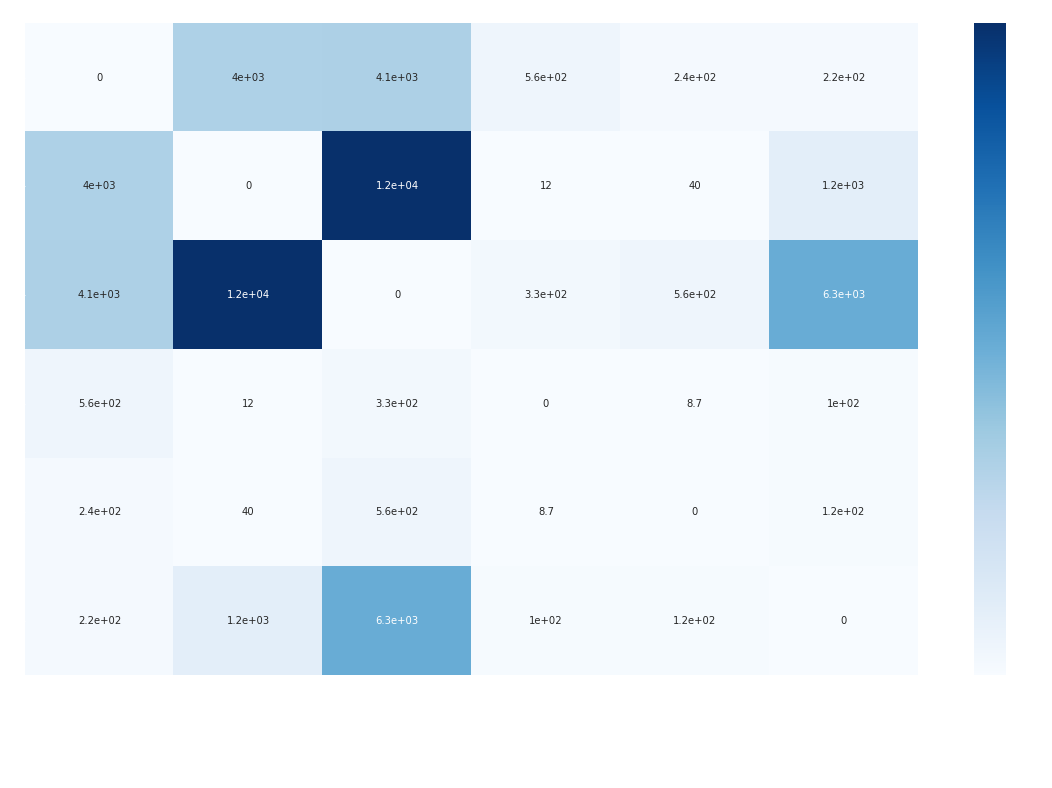

In [53]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

<a id='data_range'> </a>

## Date Range

In [121]:
days_check = [90, 180, 360,]

for day in days_check: 
    train_days_new = day
    print('\n -----------')
    print(f'{train_days_new} days of data: ')
    train_set_conv_processed_new, train_set_revenue_processed_new = create_training_set(train_set_conv, train_set_revenue, None, online_aq_ids, revenue_limit, cur_date, train_days)

    service_qual_speeds_new = list(train_set_revenue_processed_new.max_speed_qual.unique())
    marketing_tier_groups_new = list(train_set_revenue_processed_new.marketing_tier_group.unique())

    (mdl_conv_new, conv_model_report_new), mdl_rev_new, encoder_conv_new, encoder_rev_new = build_model_oversample(train_set_conv_processed_new, train_set_revenue_processed_new)


 -----------
90 days of data: 
Revenue model R2: 
0.21565307723352134
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.339906, F-Score=0.688
Classification report: 
          precision    recall  f1-score
0          0.728769  0.318698  0.443464
1          0.564020  0.881388  0.687861
accuracy   0.600043  0.600043  0.600043

 -----------
180 days of data: 
Revenue model R2: 
0.21565307723352134
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.347640, F-Score=0.688
Classification report: 
          precision    recall  f1-score
0          0.725640  0.338885  0.462007
1          0.568740  0.871870  0.688413
accuracy   0.605378  0.605378  0.605378

 -----------
360 days of data: 
Revenue model R2: 
0.21565307723352134
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.348485, F-

__Observations:__

Based on the current number of attributes, 180 days data is sufficient.

# Add cart interaction flag

In [65]:
get_cartcaller_cd = """
SELECT cd.brand_skilled,
       cicl.request_id                                                cart_id,
       cd.contact_id
FROM fuse_db.core_core_interactions cci
         INNER JOIN data_warehouse.cpr_invoca_call_log cicl on cci.interaction_type_value = cicl.request_id
         LEFT JOIN data_warehouse.call_detail cd
                   ON cd.contact_id = cicl.contact_id
                       AND cd.call_type = 'I'
                       AND cd.call_purpose = 'Sales'
                       AND cd.is_queue_opp = 1
                       AND cd.abandon_code = 1
         LEFT JOIN data_warehouse.match_orders_calls moc
                   ON cd.contact_id = moc.contact_id
                       AND moc.order_action = 'Scheduled'
WHERE interaction_type_id = 3
AND cd.date_sort_prequeue_start BETWEEN '{start_date}' AND '{end_date}'
AND cd.brand_skilled IN ('ATT')
;
"""

In [66]:
df_cart_callers = pd.read_sql_query(get_cartcaller_cd.format(start_date= '2020-03-02', end_date= cur_date), con)

In [68]:
df_cart_callers['contact_id'].unique()

array([132613004854, 132613532288, 132682449635, ..., 195790931434,
       196331300470, 196800914884])

In [94]:
train_set_conv_2 = train_set_conv.copy(deep=True)
train_set_revenue_2 = train_set_revenue.copy(deep=True)

train_set_conv_2['cartcaller_flag'] = 0
train_set_conv_2.loc[train_set_conv_2['contact_id'].astype(int).isin(df_cart_callers['contact_id'].unique()), 'cartcaller_flag'] = 1

train_set_revenue_2['cartcaller_flag'] = 0
train_set_revenue_2.loc[train_set_revenue_2['contact_id'].astype(int).isin(df_cart_callers['contact_id'].unique()), 'cartcaller_flag'] = 1

In [114]:
train_days = 360
train_set_conv_2['cartcaller_flag'] = train_set_conv_2['cartcaller_flag'].astype('category')
train_set_revenue_2['cartcaller_flag'] = train_set_revenue_2['cartcaller_flag'].astype('category')

train_set_conv_processed_2, train_set_revenue_processed_2 = create_training_set(train_set_conv_2, train_set_revenue_2, None, online_aq_ids, revenue_limit, cur_date, train_days)

<a id='correlation'> </a>

# Independence Test


In [115]:
[resultant_chi_2, resultant_p_2] = chi_square_test(train_set_conv_processed_2[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'is_weekday', 'channel_is_ppc', 'cartcaller_flag', 'is_converted']])

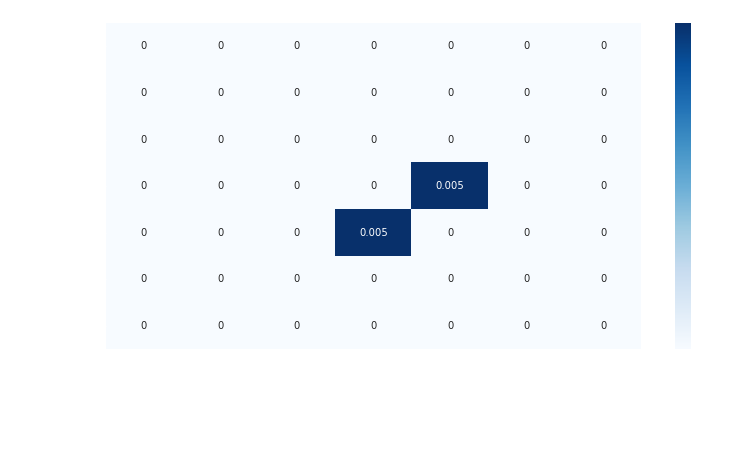

In [300]:
# Plotting p-values
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p_2,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

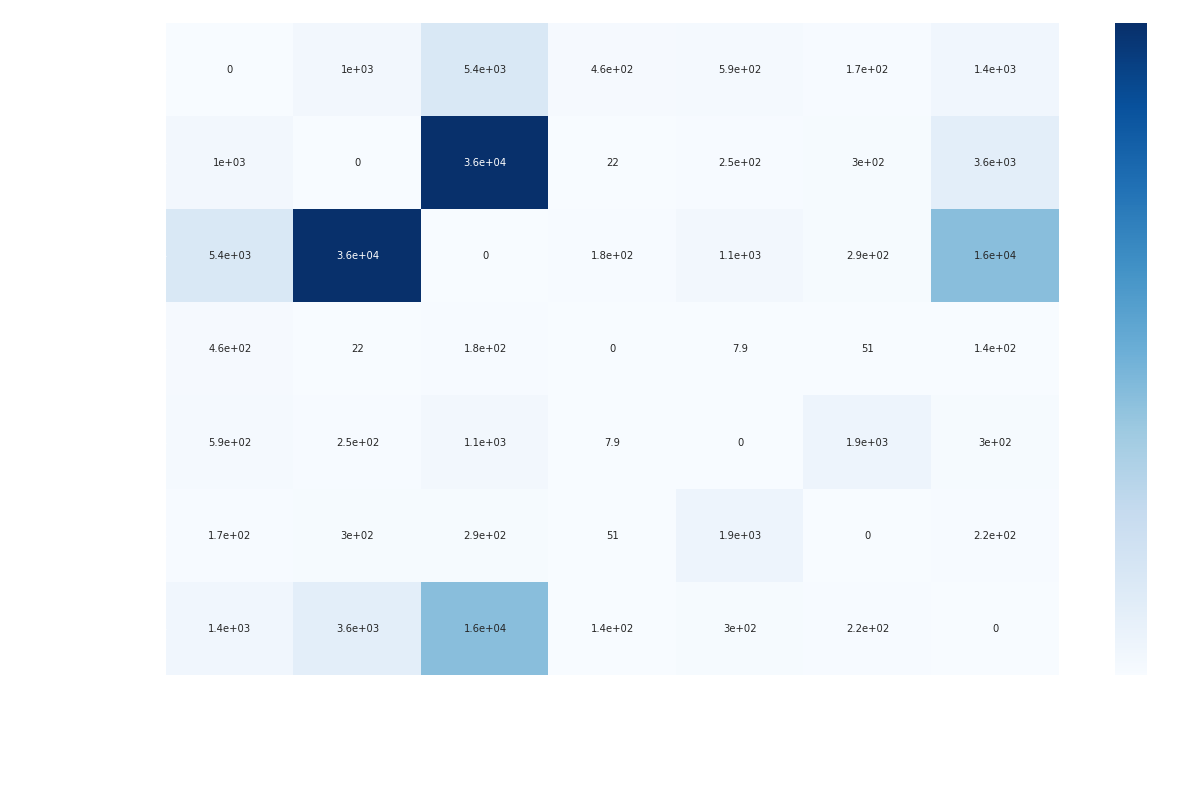

In [158]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi_2, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
g.set_yticklabels(g.get_yticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

In [303]:
contingency_conv = pd.crosstab(train_set_conv_processed_2['cartcaller_flag'], train_set_conv_processed_2['is_converted'])

chi_v, p, dof, expected = chi2_contingency(contingency_conv)
chi2.ppf(0.95, dof)

3.841458820694124

In [187]:
from sklearn.feature_selection import  mutual_info_classif

In [199]:
train_set_conv_processed_2_c = train_set_conv_processed_2.copy(deep=True)
train_set_conv_processed_2_c.replace({'NA': -1}, inplace=True)
independentvars = train_set_conv_processed_2_c[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'is_weekday', 'channel_is_ppc', 'cartcaller_flag']]
mutual_info = mutual_info_classif(independentvars, train_set_conv_processed_2_c['is_converted'])

mutual_info = pd.Series(mutual_info)
mutual_info.index = independentvars.columns
mutual_info.sort_values(ascending=False)

/Users/xiaoli.qui/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


max_speed_qual        0.053161
consent_flag          0.024444
is_weekday            0.015352
intent_lookup_flag    0.014862
channel_is_ppc        0.011980
cartcaller_flag       0.000963
dtype: float64

In [202]:
from sklearn.feature_selection import SelectKBest
sel_five_cols = SelectKBest(mutual_info_classif, k=3)
sel_five_cols.fit(independentvars, train_set_conv_processed_2_c['is_converted'])
independentvars.columns[sel_five_cols.get_support()]

/Users/xiaoli.qui/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Index(['consent_flag', 'max_speed_qual', 'is_weekday'], dtype='object')

In [154]:
# A look at the 
cart_callers_conv = train_set_conv_2[train_set_conv_2['cartcaller_flag']==1].groupby(by=['intent_lookup_flag', 'consent_flag']).agg({'contact_id': lambda x:x.nunique(), 'is_converted':'sum'}).reset_index()
cart_callers_conv['conversion'] = round(cart_callers_conv['is_converted'] / cart_callers_conv['contact_id'], 4)
cart_callers_conv['call_ratio'] = cart_callers_conv['contact_id']/cart_callers_conv['contact_id'].sum()
cart_callers_conv.sort_values(by=['call_ratio'], ascending=[False])

intent_lookup_flag  consent_flag  contact_id  is_converted  conversion  \
3                   1             1        4739          2626      0.5541   
5                   2             1        2192           821      0.3745   
2                   1             0         797           292      0.3664   
4                   2             0         420            72      0.1714   
1                   0             1         134            38      0.2836   
0                   0             0          19             3      0.1579   

   call_ratio  
3    0.570895  
5    0.264065  
2    0.096013  
4    0.050596  
1    0.016143  
0    0.002289

In [157]:
# A look at the overall population
ncart_callers_conv = train_set_conv_2[train_set_conv_2['cartcaller_flag']==0].groupby(by=['intent_lookup_flag', 'consent_flag']).agg({'contact_id': lambda x:x.nunique(), 'is_converted':'sum'}).reset_index()
ncart_callers_conv['conversion'] = round(ncart_callers_conv['is_converted'] / ncart_callers_conv['contact_id'], 4)
ncart_callers_conv['call_ratio'] = ncart_callers_conv['contact_id']/ncart_callers_conv['contact_id'].sum()
ncart_callers_conv.sort_values(by=['call_ratio'], ascending=[False])


intent_lookup_flag  consent_flag  contact_id  is_converted  conversion  \
3                   1             1      208953         99479      0.4761   
5                   2             1      137368         49079      0.3573   
2                   1             0       70070         19766      0.2821   
4                   2             0       44124          7826      0.1774   
1                   0             1       19511          5683      0.2913   
0                   0             0        6650           500      0.0752   

   call_ratio  
3    0.429347  
5    0.282258  
2    0.143977  
4    0.090664  
1    0.040090  
0    0.013664

In [159]:
train_set_conv_2.groupby(by=['cartcaller_flag', 'channel_is_ppc']).agg({'contact_id': lambda x:x.nunique(), 'is_converted':'sum'}).reset_index()

cartcaller_flag  channel_is_ppc  contact_id  is_converted
0               0               0      172437         59603
1               0               1      314239        122730
2               1               0        4624          2063
3               1               1        3677          1789

In [272]:
def drop_attributes_rand(train_set_conv_processed, train_set_revenue_processed):
    """
    
    """
    cols = train_set_conv_processed.drop(columns=['is_converted']).columns
    f1_1_best = 0
    f1_0_best = 0
    accuracy_best = 0
    recall_1_best = 0
    cols_best = cols
    dict_save = {'f1_1_best': {'cols_best': cols_best, 'conv_model_report': None},
                'f1_0_best': {'cols_best': cols_best, 'conv_model_report': None},
                'accuracy_best': {'cols_best': cols_best, 'conv_model_report': None},
                'recall_1_best': {'cols_best': cols_best, 'conv_model_report': None},
                }

    # use 3 attributes or more
    cols_combs = []
    for L in range(0, len(cols)+1):
        for subset in combinations(cols, L):
            if (len(subset) >= 3) & ('max_speed_qual' in subset) & ('marketing_tier_group' not in subset):     #TODO: change to 3 
                cols_combs.append(list(subset))
                
    for cols_comb in cols_combs:
        print('-----------------')
        print('Current attributes: ', cols_comb)
        train_set_conv_processed_d = pd.concat([train_set_conv_processed[cols_comb], train_set_conv_processed['is_converted']], axis= 1)
        train_set_revenue_processed_d = pd.concat([train_set_revenue_processed[cols_comb], train_set_revenue_processed[['is_converted', 'fkrs_revenue']]], axis= 1)

#         service_qual_speeds_new = list(train_set_revenue_processed_d.max_speed_qual.unique())
#         marketing_tier_groups_new = ['NA'] #list(train_set_revenue_processed_d.marketing_tier_group.unique())

        (mdl_conv_new, conv_model_report_new), mdl_rev_new, encoder_conv_new, encoder_rev_new = build_model_oversample(train_set_conv_processed_d, train_set_revenue_processed_d)
        f1_1_cur = conv_model_report_new['1']['f1-score']
        f1_0_cur = conv_model_report_new['0']['f1-score']
        accuracy_cur = conv_model_report_new['accuracy']
        recall_1_cur = conv_model_report_new['1']['recall']
        
        if (f1_1_cur > f1_1_best):
            dict_save['f1_1_best']['cols_best'] = cols_comb
            dict_save['f1_1_best']['conv_model_report'] = conv_model_report_new
            f1_1_best = f1_1_cur
        elif (f1_0_cur > f1_0_best):
            dict_save['f1_0_best']['cols_best'] = cols_comb
            dict_save['f1_0_best']['conv_model_report'] = conv_model_report_new
            f1_0_best = f1_0_cur
        elif (accuracy_cur >= accuracy_best):
            dict_save['accuracy_best']['cols_best'] = cols_comb
            dict_save['accuracy_best']['conv_model_report'] = conv_model_report_new
            accuracy_best = accuracy_cur
        elif recall_1_cur > recall_1_best: 
            dict_save['recall_1_best']['cols_best'] = cols_comb
            dict_save['recall_1_best']['conv_model_report'] = conv_model_report_new
            recall_1_best = recall_1_cur
            
    print('Best combination of attributes that yields the best accuracy if: ', dict_save['accuracy_best']['cols_best'])
    
    return tuple([cols_combs, dict_save])

In [273]:
all_combs, best_attritubes = drop_attributes_rand(train_set_conv_processed_2, train_set_revenue_processed_2)

-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'max_speed_qual']
Revenue model R2: 
0.2133217265398033
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.354458, F-Score=0.685
Classification report: 
          precision    recall  f1-score
0          0.707908  0.394660  0.506786
1          0.580353  0.837158  0.685493
accuracy   0.615909  0.615909  0.615909
-----------------
Current attributes:  ['intent_lookup_flag', 'channel_is_ppc', 'max_speed_qual']
Revenue model R2: 
0.2136226607051246
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.330586, F-Score=0.685
Classification report: 
          precision    recall  f1-score
0          0.744437  0.234664  0.356843
1          0.545734  0.919440  0.684929
accuracy   0.577052  0.577052  0.577052
-----------------
Current attributes:  ['intent_lookup_flag', 'is_weekday', 

Classification report: 
          precision    recall  f1-score
0          0.692265  0.365336  0.478270
1          0.568918  0.837596  0.677595
accuracy   0.601466  0.601466  0.601466
-----------------
Current attributes:  ['consent_flag', 'is_weekday', 'max_speed_qual', 'cartcaller_flag']
Revenue model R2: 
0.21556992588566848
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.329453, F-Score=0.678
Classification report: 
          precision    recall  f1-score
0          0.700139  0.297235  0.417308
1          0.553931  0.872698  0.677702
accuracy   0.584966  0.584966  0.584966
-----------------
Current attributes:  ['channel_is_ppc', 'is_weekday', 'max_speed_qual', 'cartcaller_flag']
Revenue model R2: 
0.21534932788813232
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.320311, F-Score=0.678
Classification report: 
          precision    recal

R2 score for revenue model is consistent. 

Interestingly, f1-scores is ralatively good for the follwoing case: 

```text
Current attributes:  ['channel_is_ppc', 'is_weekday', 'max_speed_qual']
Revenue model R2: 
0.21364549696503632
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.348005, F-Score=0.678
Classification report: 
          precision    recall  f1-score
0          0.668757  0.617085  0.641883
1          0.644549  0.694351  0.668524
accuracy   0.655718  0.655718  0.655718]
```
```text
Current attributes:  ['is_weekday', 'max_speed_qual', 'cartcaller_flag']
Revenue model R2: 
0.21482711899824314
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.338129, F-Score=0.672
Classification report: 
          precision    recall  f1-score
0          0.670910  0.599952  0.633450
1          0.638216  0.705716  0.670271
accuracy   0.652834  0.652834  0.652834
```

In [290]:
def keep_3_attributes_at_least(train_set_conv_processed, train_set_revenue_processed, attri_keep_list=['max_speed_qual', 'intent_lookup_flag', 'consent_flag']):
    """
    
    """
    cols = train_set_conv_processed.drop(columns=['is_converted']).columns
    f1_1_best = 0
    f1_0_best = 0
    accuracy_best = 0
    recall_1_best = 0
    cols_best = cols
    dict_save = {'f1_1_best': {'cols_best': cols_best, 'conv_model_report': None},
                'f1_0_best': {'cols_best': cols_best, 'conv_model_report': None},
                'accuracy_best': {'cols_best': cols_best, 'conv_model_report': None},
                'recall_1_best': {'cols_best': cols_best, 'conv_model_report': None},
                }

    # keeping the attributes in the attri_keep_list, add at least 1 other attribute
    cols_combs = []
    for L in range(0, len(cols)+1):
        for subset in combinations(cols, L):
            if (len(subset) >= 3) & (all(elem in subset for elem in attri_keep_list)) & ('marketing_tier_group' not in subset):    
                cols_combs.append(list(subset))
#     print(cols_combs)
                
    for cols_comb in cols_combs:
        print('-----------------')
        print('Current attributes: ', cols_comb)
        train_set_conv_processed_d = pd.concat([train_set_conv_processed[cols_comb], train_set_conv_processed['is_converted']], axis= 1)
        train_set_revenue_processed_d = pd.concat([train_set_revenue_processed[cols_comb], train_set_revenue_processed[['is_converted', 'fkrs_revenue']]], axis= 1)

        (mdl_conv_new, conv_model_report_new), mdl_rev_new, encoder_conv_new, encoder_rev_new = build_model_oversample(train_set_conv_processed_d, train_set_revenue_processed_d)
        f1_1_cur = conv_model_report_new['1']['f1-score']
        f1_0_cur = conv_model_report_new['0']['f1-score']
        accuracy_cur = conv_model_report_new['accuracy']
        recall_1_cur = conv_model_report_new['1']['recall']
        
        if (f1_1_cur > f1_1_best):
            dict_save['f1_1_best']['cols_best'] = cols_comb
            dict_save['f1_1_best']['conv_model_report'] = conv_model_report_new
            f1_1_best = f1_1_cur
        elif (f1_0_cur > f1_0_best):
            dict_save['f1_0_best']['cols_best'] = cols_comb
            dict_save['f1_0_best']['conv_model_report'] = conv_model_report_new
            f1_0_best = f1_0_cur
        elif (accuracy_cur >= accuracy_best):
            dict_save['accuracy_best']['cols_best'] = cols_comb
            dict_save['accuracy_best']['conv_model_report'] = conv_model_report_new
            accuracy_best = accuracy_cur
        elif recall_1_cur > recall_1_best: 
            dict_save['recall_1_best']['cols_best'] = cols_comb
            dict_save['recall_1_best']['conv_model_report'] = conv_model_report_new
            recall_1_best = recall_1_cur
            
    print('Best combination of attributes that yields the best accuracy if: ', dict_save['accuracy_best']['cols_best'])

    return tuple([cols_combs, dict_save])

<a id='training'> </a>

# Training with Different Attributes


In [295]:
all_combs_2, best_attritubes_2 = keep_3_attributes_at_least(train_set_conv_processed_2, train_set_revenue_processed_2)

-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'max_speed_qual']
Revenue model R2: 
0.2133217265398033
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.339339, F-Score=0.685
Classification report: 
          precision    recall  f1-score
0          0.706721  0.393918  0.505870
1          0.579872  0.836530  0.684947
accuracy   0.615224  0.615224  0.615224
-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'channel_is_ppc', 'max_speed_qual']
Revenue model R2: 
0.21429833761623696
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.338872, F-Score=0.687
Classification report: 
          precision    recall  f1-score
0          0.732778  0.295741  0.421407
1          0.558849  0.892152  0.687220
accuracy   0.593947  0.593947  0.593947
-----------------
Current attributes:  ['intent_lookup_flag

<a id='tldr'> </a>

# TL;DR

- [180 days of data](#data_range) seems to be enough.
- `max_speed_qual`, `intent_lookup_flag`, `consent_flag` are still essential
- `is_weekday` and `channel_is_ppc` added very little value if there is any. 